В качестве датасета я выбрал Stroke Prediction Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-datase

Вопрос медицины стоит очень остро, MachineLearning является топ кандидатом для решения задачи определения возможности инсульта у людей по некоторым признакам.

Это задача бинарной классификации с двумя классами: инсульт вероятен, и инсульт не вероятен.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [6]:
len(data)

5110

Информация о признаках:

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not

In [7]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Посмотрим на признаки:

1. колонку id - можно удалить, остальные значения представляют ценность для предсказания.
2. 5 числовых и 5 категориальных признаков, хотя колонки `hypertension` и `heart_disease` можно отнести к категориальным.
   

In [33]:
data = data.drop('id', axis=1)
features = data.columns.values.copy().tolist()
features

KeyError: "['id'] not found in axis"

Поищем протухшие значения:

In [9]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

В `BMI` колонке есть пропущенные значения (у людей не измерили вес), с учетом специфики признака, можно заменить недостающие значения на среднее из датасета:

In [10]:
data['bmi'].mean()

28.893236911794666

Среднее значение ~= 28.89

In [11]:
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

Проверим:

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Посмотрим на уникальные значения в категориальных фичах:

In [13]:
for column in ('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'):
    print(f'{column}: {data[column].unique()}')

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Посмотрим на Unknown в `smoking_status`:

In [14]:
(data['smoking_status'] == 'Unknown').sum()

1544

Значений примерно треть от общего числа, пусть будет отдельной категорией

Проанализируем числовые значения:

In [15]:
numeric_columns = ['age', 'avg_glucose_level', 'bmi']
data[numeric_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.698018
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.800000
50%,45.000000,91.885000,28.400000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


Каких либо сильных отклонений в данных нет

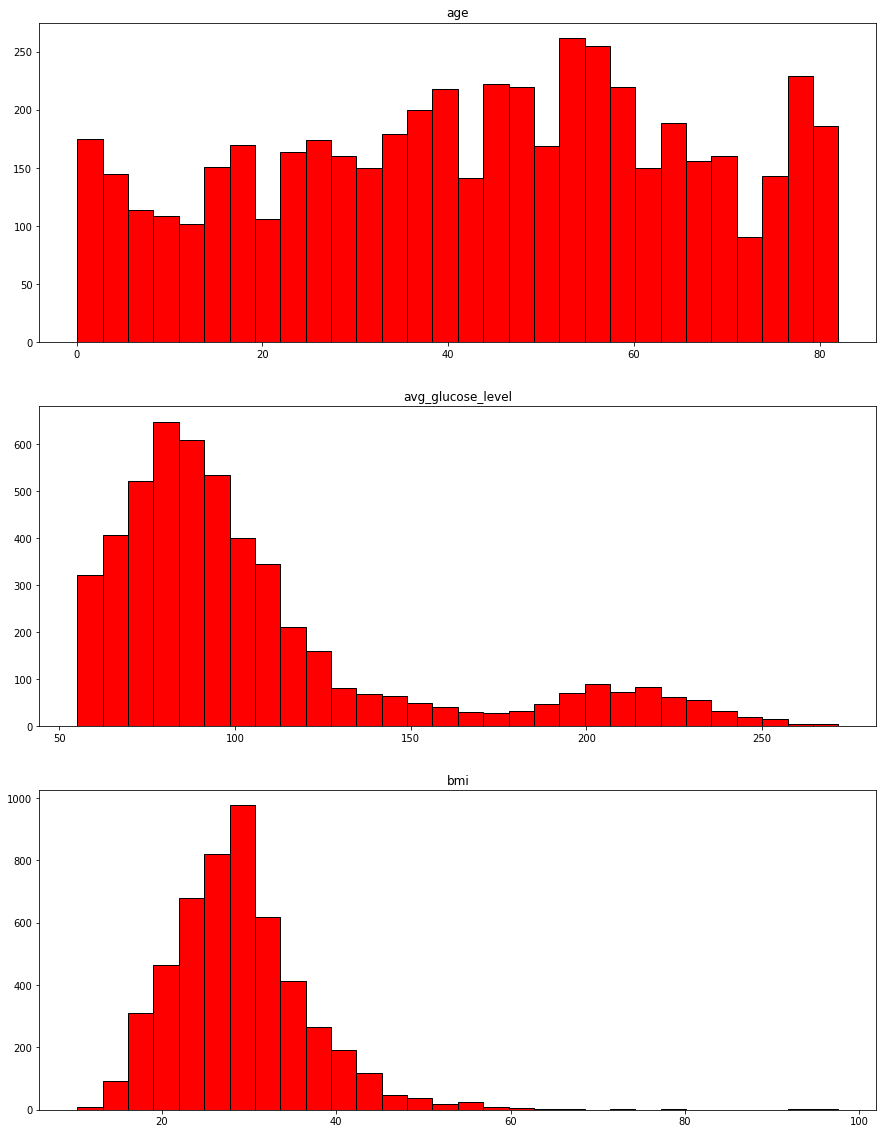

In [20]:
fig, ax_hist = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(15, 20))
for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], bins=30, alpha=1.0, color='red', edgecolor='black', ax=ax_hist[i])
    ax_hist[i].set(xlabel='', ylabel='', title=f'{col}')
plt.show()

В `bmi` есть значения похожие на выбросы, но если подумать то можно предположить возможность существования людей с bmi >= 80

In [25]:
print(data[numeric_columns].median())
print(data[numeric_columns].mean())
print(data[numeric_columns].skew())

age                  45.000
avg_glucose_level    91.885
bmi                  28.400
dtype: float64
age                   43.226614
avg_glucose_level    106.147677
bmi                   28.893237
dtype: float64
age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.076716
dtype: float64


У признаков `avg_glucose_level` и `bmi` есть небольшие смещения

Оценим класс `stroke` на сбалансированность:

In [26]:
print((data['stroke'] == 0).sum())
print((data['stroke'] == 1).sum())

4861
249


Данные несбалансированные, для решения этой проблему можно использовать некоторые способы, такие как добор данных для датасета (неприменимо в нашем случае), или сделать перебалансировку данных, например семплированием

Нормализуем данные:

In [28]:
for col in numeric_columns:
    mean, std = data[col].mean(), data[col].std()
    data[col] = (data[col] - mean) / std
data[numeric_columns].describe()

,age,avg_glucose_level,bmi
count,5.110000e+03,5.110000e+03,5.110000e+03
mean,1.668594e-17,1.112396e-17,5.561978e-18
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.908074e+00,-1.126848e+00,-2.415328e+00
25%,-8.060363e-01,-6.382598e-01,-6.616297e-01
50%,7.842450e-02,-3.149637e-01,-6.407324e-02
75%,7.859932e-01,1.753909e-01,5.075025e-01
max,1.714677e+00,3.656787e+00,8.925254e+00


Посмотрим на матрицу коррелированности признаков:

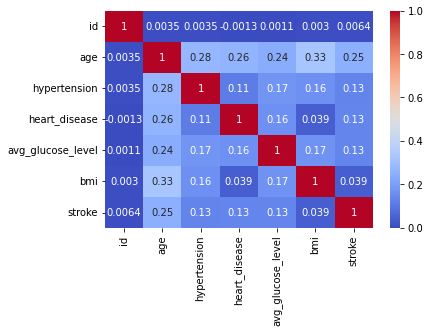

In [29]:
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.show()

Коррелированности нет